In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from scipy.interpolate import RectBivariateSpline
from datetime import datetime, timedelta

import calendar

import glob

import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Data

## Import data

In [2]:
ds = xr.open_zarr('pm_ds.zarr')

## PM25 calcuations
PM25     = 1.33 (NH4 + NIT  + SO4)
         + BCPI + BCPO
         + 2.1 (OCPO + 1.16 OCPI) + 1.16 SOA
         + DST1 + 0.38 DST2 + 1.86 SALA

In [3]:
#molecular weights of species
mw_species = {
    'NH4': 18.,
    'NIT': 62.,
    'SO4': 96.,
    'BCPI': 12.,
    'OCPI': 12.,
    'BCPO': 12.,
    'OCPO': 12.,
    'DST1': 29.,
    'DST2': 29.,
    'SALA': 31.4,
}
#list of pm species
pm_species = list(mw_species.keys())

In [4]:
utils.ppb_to_ug(ds, pm_species, mw_species)

#### drop if the above works
stp_p = 101325 # Pa
stp_t = 298. # K

ppb_ugm3 = (stp_p * 1e6 / stp_t /8.314) 

for spec in pm_species:
    attrs = ds[spec].attrs
    ds[spec] = ds[spec]*mw_species[spec]*ppb_ugm3
    attrs['units'] = 'μg m-3'
    ds[spec].attrs.update(attrs)

In [6]:
ds['calc_PM25'] = (1.33 * (ds['NH4'] + ds['NIT'] + ds['SO4'])
                     + (ds['BCPO'] + ds['BCPI'])
                     + 2.1*(ds['OCPO'] + 1.16*ds['OCPI'])
                     + ds['DST1'] + 0.38*ds['DST2']
                     + 1.86*ds['SALA'])

ds['inorganic_PM25'] = (1.33 * (ds['NH4'] + ds['SO4'] + ds['NIT']))
ds['organic_PM25'] = ((ds['BCPO'] + ds['BCPI'])
                     + 2.1*(ds['OCPO'] + 1.16*ds['OCPI'])
                     + ds['DST1'] + 0.38*ds['DST2']
                     + 1.86*ds['SALA'])

ds['calc_PM25'].attrs.update({
    'units': 'μg m-3', 'full_name': 'Total PM2.5', 'name': 'PM25'
})
ds['monthly_mean_calc_PM25'] = ds['calc_PM25'].groupby('time.month').mean()
ds['monthly_mean_calc_PM25'].attrs.update({'units':'μg m-3', 'full_name': 'Monthly Mean PM2.5', 'name': 'PM25'})
ds['monthly_mean_inorganic_PM25'] = ds['inorganic_PM25'].groupby('time.month').mean()
ds['monthly_mean_inorganic_PM25'].attrs.update({'units':'μg m-3', 'full_name': 'Monthly Mean Inorganic PM2.5', 'name': 'PM25'})
ds['monthly_mean_organic_PM25'] = ds['organic_PM25'].groupby('time.month').mean()
ds['monthly_mean_organic_PM25'].attrs.update({'units':'μg m-3', 'full_name': 'Monthly Mean Organic PM2.5', 'name': 'PM25'})
for species in pm_species:
    ds[f'monthly_mean_{species}'] = ds[f'{species}'].groupby('time.month').mean()
    ds[f'monthly_mean_{species}'].attrs.update({'units':'μg m-3', 'full_name': f'Monthly Mean {species}', 'name': f'{species}'})

# PM Plots

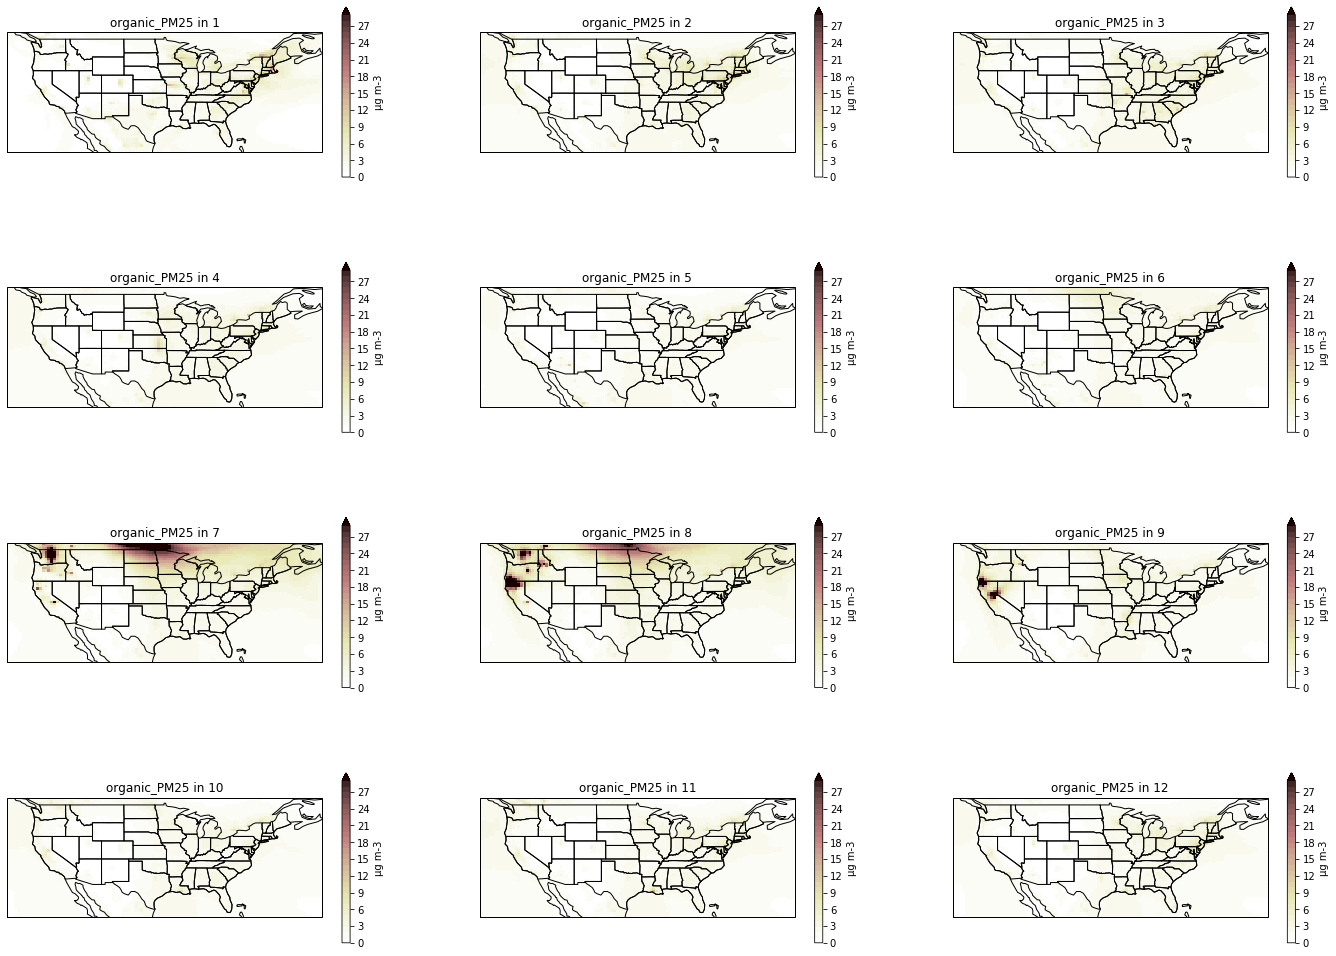

In [9]:
plotting.monthly_mean(ds.sel(model_name = 'MODEL'), 'organic_PM25',np.arange(0,30,1))

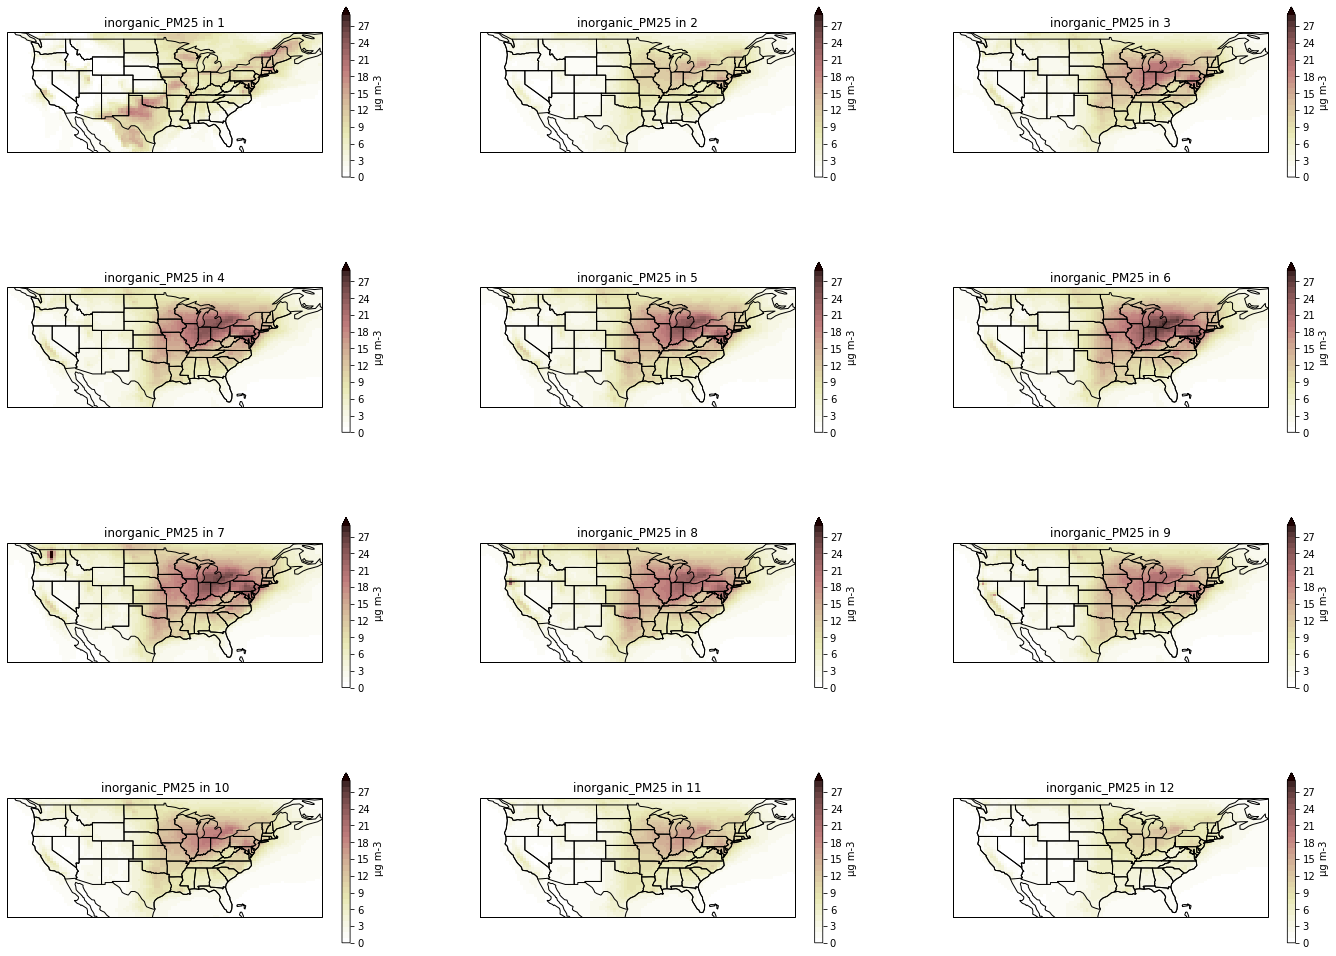

In [10]:
plotting.monthly_mean(ds.sel(model_name = 'MODEL'), 'inorganic_PM25',np.arange(0,30,1))

# Species Plots

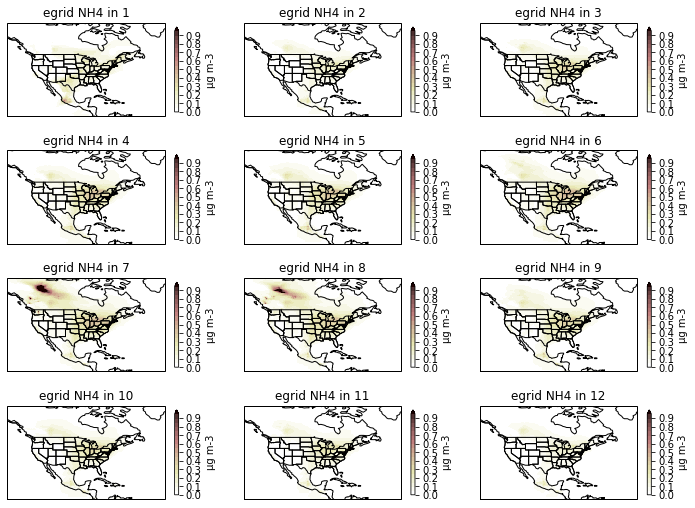

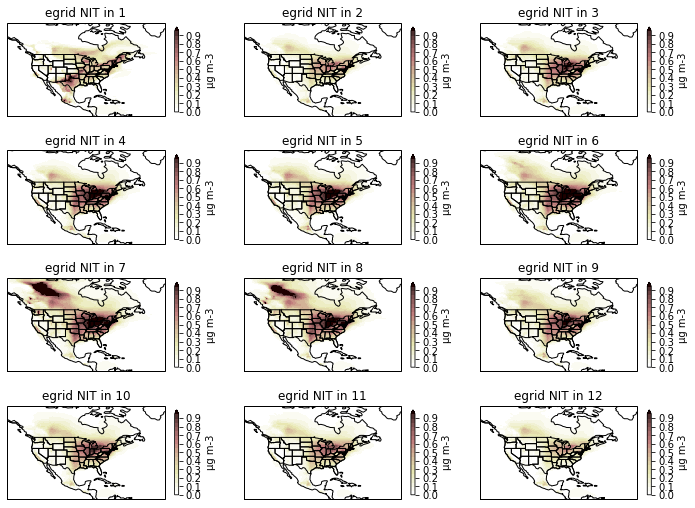

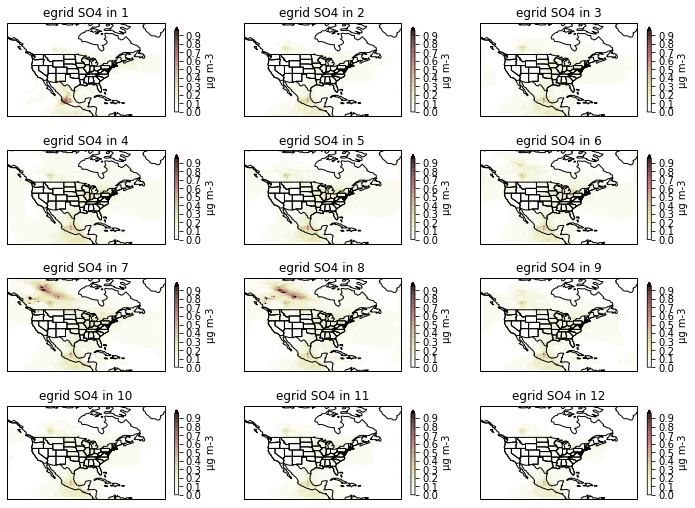

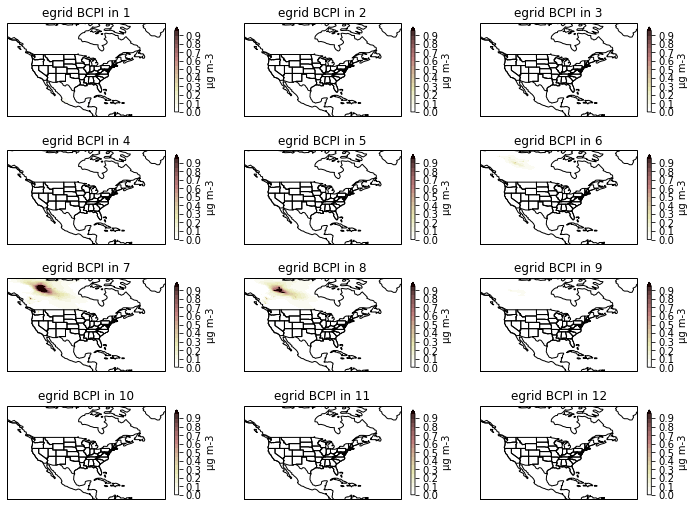

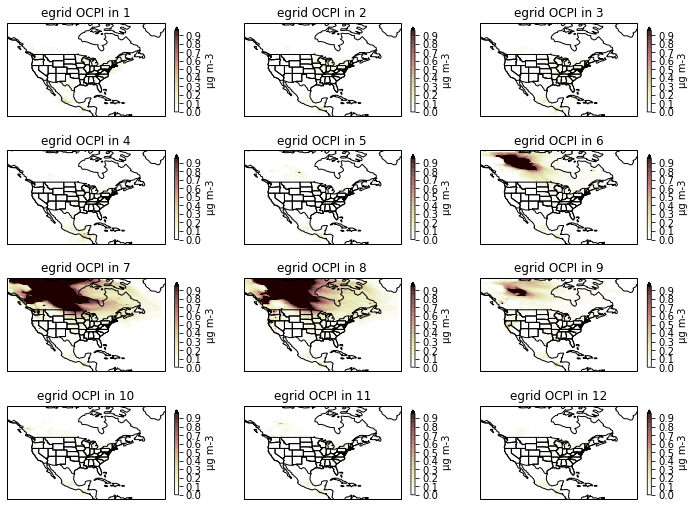

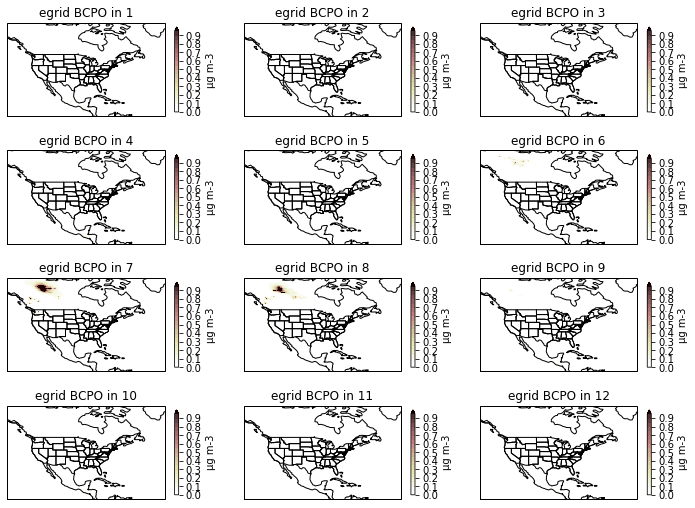

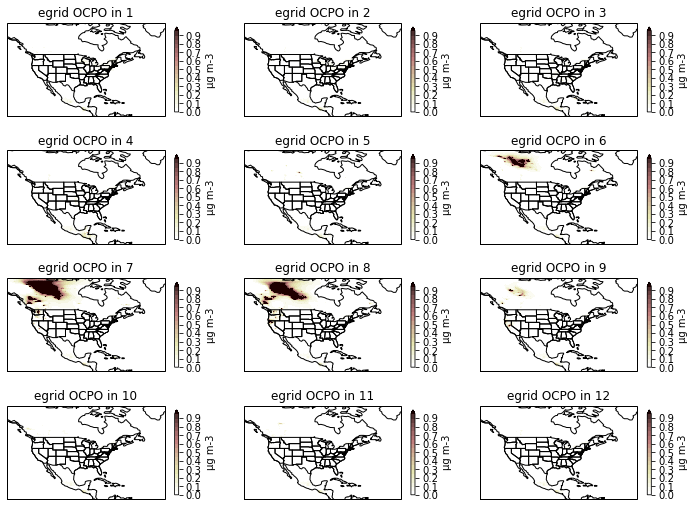

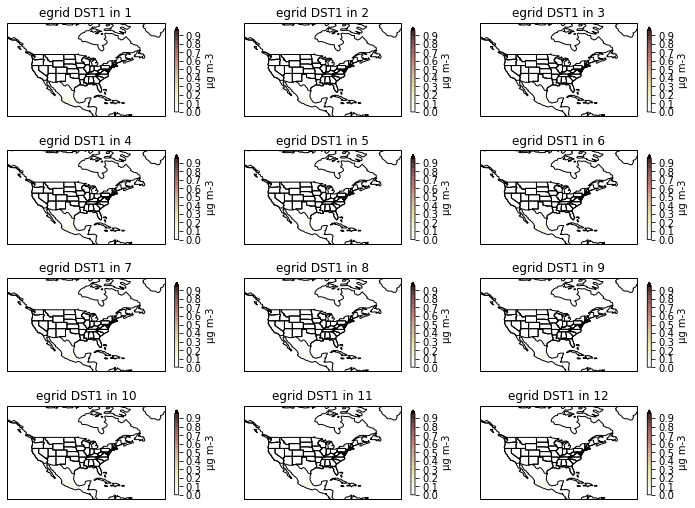

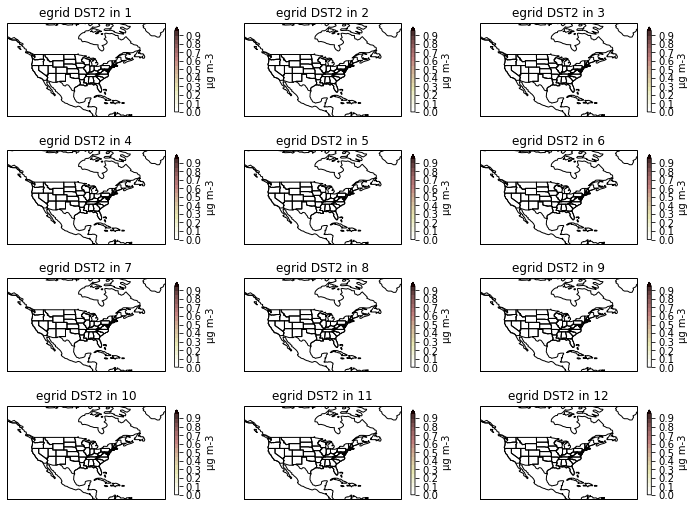

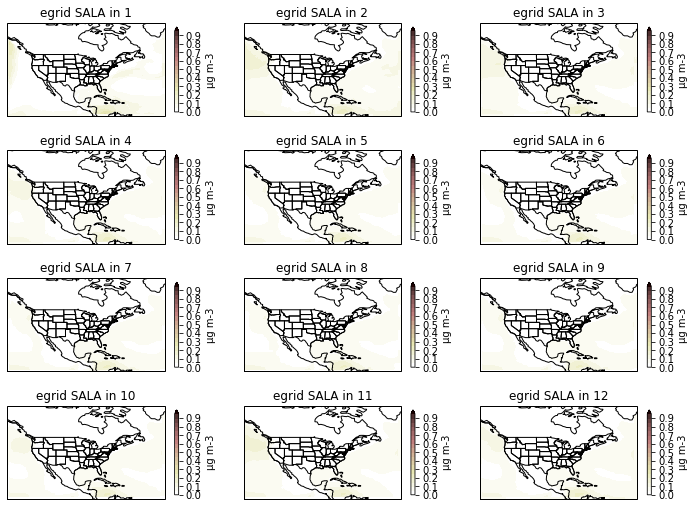

In [8]:
for species in pm_species:
    plotting.monthly_mean(ds_egrid, species, np.arange(0,1,.05))
